# dAiv AI_Competition[2024]_Basic Baseline for PyTorch

## Import Libraries

In [1]:
from os import path, mkdir

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.models
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [2]:
!nvidia-smi

Wed Aug  7 15:17:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |   5661MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 6

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [4]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [5]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (512, 512)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9866), Valid(3430), Test(3347)


## Data Augmentation if needed

In [7]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [8]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer
])

In [9]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9866)


## DataLoader

In [10]:
# Set Batch Size
BATCH_SIZE = 64

In [11]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


## Define Model

### 0. BaselineModel

In [15]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, img_size: int, num_classes: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Assuming you want to connect to a fully connected layer after flattening
        # Calculate the size of the flattened features after 3 pooling layers
        self.fc_size = output_channel * (img_size // 2**3) * (img_size // 2**3)
        self.fc = nn.Linear(self.fc_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

### 2. ResNetWithAttention

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        
        # Query, Key, Value 계산
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)  # [B, N, N]
        
        # Attention 계산
        attention = self.softmax(energy)
        
        # Value 계산
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        # Attention 결과와 입력을 결합
        out = self.gamma * out + x
        return out

In [15]:
class ResNetImageClassifierWithAttention(nn.Module):
    def __init__(self, num_classes: int):
        super(ResNetImageClassifierWithAttention, self).__init__()
        
        # ResNet18 모델 불러오기 (사전 학습된 모델을 사용하지 않음)
        self.resnet = torchvision.models.resnet18(pretrained=False)
        
        # ResNet에서 Feature Extractor로 사용할 레이어 (Pooling 전까지)
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Attention Layer 추가
        self.attention = SelfAttention(in_dim=512)  # ResNet18의 마지막 레이어 채널 수는 512
        
        # Adaptive Average Pooling과 Fully Connected Layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Feature Extraction
        x = self.features(x)
        
        # Attention 적용
        x = self.attention(x)
        
        # Global Average Pooling
        x = self.avg_pool(x)
        
        # Flatten 후 Classification
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### 2. ResNet

In [16]:
class ResNetImageClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super(ResNetImageClassifier, self).__init__()
        
        # Pretrained ResNet 모델 불러오기 (여기서는 ResNet18 사용)
        self.resnet = torchvision.models.resnet18(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [17]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    input_channel=3, output_channel=64,
    img_size=IMG_SIZE[0], num_classes=CLASS_LABELS
)

In [18]:
# Initialize Model
model = ResNetImageClassifierWithAttention(num_classes=CLASS_LABELS)
model.to(device)

/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetImageClassifierWithAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [21]:
LEARNING_RATE = 1e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

## Training Loop

In [22]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [23]:
# Set Epoch Count
num_epochs = 100

Running Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/155 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Output()

Epoch [ 1/100], Step [155/155], Loss: 2.267057, Valid Acc: 30.058315%, Valid Loss: 2.012794

Epoch [ 2/100], Step [155/155], Loss: 1.760425, Valid Acc: 34.927106%, Valid Loss: 1.897976

Epoch [ 3/100], Step [155/155], Loss: 1.781223, Valid Acc: 38.192415%, Valid Loss: 1.831000

Epoch [ 4/100], Step [155/155], Loss: 1.467354, Valid Acc: 39.620984%, Valid Loss: 1.773426

Epoch [ 5/100], Step [155/155], Loss: 1.385718, Valid Acc: 42.157438%, Valid Loss: 1.703903


Epoch [ 6/100], Step [155/155], Loss: 1.679326, Valid Acc: 40.233234%, Valid Loss: 1.764440

Epoch [ 7/100], Step [155/155], Loss: 2.117175, Valid Acc: 43.527704%, Valid Loss: 1.658467

Epoch [ 8/100], Step [155/155], Loss: 1.371667, Valid Acc: 44.169092%, Valid Loss: 1.637691

Epoch [ 9/100], Step [155/155], Loss: 1.742424, Valid Acc: 45.189500%, Valid Loss: 1.610307

Epoch [10/100], Step [155/155], Loss: 1.074824, Valid Acc: 45.743439%, Valid Loss: 1.608528


Epoch [11/100], Step [155/155], Loss: 1.660084, Valid Acc: 46.209911%, Valid Loss: 1.581065

Epoch [12/100], Step [155/155], Loss: 1.416891, Valid Acc: 49.912530%, Valid Loss: 1.492308

Epoch [13/100], Step [155/155], Loss: 1.449165, Valid Acc: 47.551015%, Valid Loss: 1.534560

Epoch [14/100], Step [155/155], Loss: 2.080544, Valid Acc: 50.029153%, Valid Loss: 1.456687

Epoch [15/100], Step [155/155], Loss: 2.034194, Valid Acc: 48.600575%, Valid Loss: 1.495040


Epoch [16/100], Step [155/155], Loss: 1.532482, Valid Acc: 50.262386%, Valid Loss: 1.448650

Epoch [17/100], Step [155/155], Loss: 1.856764, Valid Acc: 52.769673%, Valid Loss: 1.413013

Epoch [18/100], Step [155/155], Loss: 1.456910, Valid Acc: 53.615153%, Valid Loss: 1.385516

Epoch [19/100], Step [155/155], Loss: 1.284291, Valid Acc: 51.078713%, Valid Loss: 1.434419

Epoch [20/100], Step [155/155], Loss: 2.059635, Valid Acc: 53.731763%, Valid Loss: 1.365117


Epoch [21/100], Step [155/155], Loss: 1.490524, Valid Acc: 53.148699%, Valid Loss: 1.390774

Epoch [22/100], Step [155/155], Loss: 1.099544, Valid Acc: 54.139936%, Valid Loss: 1.340042

Epoch [23/100], Step [155/155], Loss: 1.314037, Valid Acc: 56.064135%, Valid Loss: 1.296243

Epoch [24/100], Step [155/155], Loss: 1.529884, Valid Acc: 55.772597%, Valid Loss: 1.294907

Epoch [25/100], Step [155/155], Loss: 1.390352, Valid Acc: 56.093287%, Valid Loss: 1.292759


Epoch [26/100], Step [155/155], Loss: 0.798540, Valid Acc: 55.481035%, Valid Loss: 1.312293

Epoch [27/100], Step [155/155], Loss: 1.180517, Valid Acc: 57.434398%, Valid Loss: 1.256589

Epoch [28/100], Step [155/155], Loss: 1.275273, Valid Acc: 56.501454%, Valid Loss: 1.273464

Epoch [29/100], Step [155/155], Loss: 1.210881, Valid Acc: 57.376075%, Valid Loss: 1.266540

Epoch [30/100], Step [155/155], Loss: 1.677660, Valid Acc: 57.084548%, Valid Loss: 1.276866


Epoch [31/100], Step [155/155], Loss: 1.154286, Valid Acc: 57.376093%, Valid Loss: 1.261203

Epoch [32/100], Step [155/155], Loss: 1.201102, Valid Acc: 58.134103%, Valid Loss: 1.243511

Epoch [33/100], Step [155/155], Loss: 1.062704, Valid Acc: 59.650141%, Valid Loss: 1.216666

Epoch [34/100], Step [155/155], Loss: 0.766784, Valid Acc: 60.233229%, Valid Loss: 1.203244

Epoch [35/100], Step [155/155], Loss: 1.060350, Valid Acc: 58.425653%, Valid Loss: 1.238122


Epoch [36/100], Step [155/155], Loss: 1.825466, Valid Acc: 59.067053%, Valid Loss: 1.243552

Epoch [37/100], Step [155/155], Loss: 0.940338, Valid Acc: 58.134115%, Valid Loss: 1.220701

Epoch [38/100], Step [155/155], Loss: 1.641527, Valid Acc: 60.553938%, Valid Loss: 1.169721

Epoch [39/100], Step [155/155], Loss: 1.262670, Valid Acc: 60.378999%, Valid Loss: 1.180663

Epoch [40/100], Step [155/155], Loss: 0.623738, Valid Acc: 59.795922%, Valid Loss: 1.193142


Epoch [41/100], Step [155/155], Loss: 1.985485, Valid Acc: 60.378999%, Valid Loss: 1.149953

Epoch [42/100], Step [155/155], Loss: 0.761744, Valid Acc: 59.037888%, Valid Loss: 1.189020

Epoch [43/100], Step [155/155], Loss: 1.017368, Valid Acc: 60.349846%, Valid Loss: 1.161184

Epoch [44/100], Step [155/155], Loss: 0.595137, Valid Acc: 60.583073%, Valid Loss: 1.166611

Epoch [45/100], Step [155/155], Loss: 1.004430, Valid Acc: 61.370254%, Valid Loss: 1.122794


Epoch [46/100], Step [155/155], Loss: 1.049694, Valid Acc: 59.591836%, Valid Loss: 1.175006

Epoch [47/100], Step [155/155], Loss: 1.546667, Valid Acc: 62.798834%, Valid Loss: 1.103872

Epoch [48/100], Step [155/155], Loss: 1.237279, Valid Acc: 62.594742%, Valid Loss: 1.123835

Epoch [49/100], Step [155/155], Loss: 1.474278, Valid Acc: 61.195332%, Valid Loss: 1.128917

Epoch [50/100], Step [155/155], Loss: 1.487740, Valid Acc: 62.711352%, Valid Loss: 1.095014


Epoch [51/100], Step [155/155], Loss: 1.203304, Valid Acc: 63.352764%, Valid Loss: 1.093408

Epoch [52/100], Step [155/155], Loss: 1.456927, Valid Acc: 62.390667%, Valid Loss: 1.101185

Epoch [53/100], Step [155/155], Loss: 1.400505, Valid Acc: 62.069976%, Valid Loss: 1.115278

Epoch [54/100], Step [155/155], Loss: 1.139638, Valid Acc: 61.078721%, Valid Loss: 1.131066

Epoch [55/100], Step [155/155], Loss: 1.446402, Valid Acc: 63.294441%, Valid Loss: 1.065187


Epoch [56/100], Step [155/155], Loss: 1.073389, Valid Acc: 61.690962%, Valid Loss: 1.115989

Epoch [57/100], Step [155/155], Loss: 1.570270, Valid Acc: 61.895037%, Valid Loss: 1.106450

Epoch [58/100], Step [155/155], Loss: 0.963011, Valid Acc: 62.507296%, Valid Loss: 1.096610

Epoch [59/100], Step [155/155], Loss: 1.186702, Valid Acc: 63.935864%, Valid Loss: 1.046126

Epoch [60/100], Step [155/155], Loss: 0.885675, Valid Acc: 64.169091%, Valid Loss: 1.066498


Epoch [61/100], Step [155/155], Loss: 2.318616, Valid Acc: 64.344019%, Valid Loss: 1.050622

Epoch [62/100], Step [155/155], Loss: 1.099275, Valid Acc: 64.256555%, Valid Loss: 1.063988

Epoch [63/100], Step [155/155], Loss: 1.045770, Valid Acc: 63.032073%, Valid Loss: 1.093349

Epoch [64/100], Step [155/155], Loss: 1.141168, Valid Acc: 63.935864%, Valid Loss: 1.067271

Epoch [65/100], Step [155/155], Loss: 1.033874, Valid Acc: 62.653065%, Valid Loss: 1.110591


Epoch [66/100], Step [155/155], Loss: 0.550760, Valid Acc: 63.935846%, Valid Loss: 1.058234

Epoch [67/100], Step [155/155], Loss: 1.457652, Valid Acc: 64.693874%, Valid Loss: 1.030789

Epoch [68/100], Step [155/155], Loss: 1.032478, Valid Acc: 64.489794%, Valid Loss: 1.064725

Epoch [69/100], Step [155/155], Loss: 1.282400, Valid Acc: 63.265306%, Valid Loss: 1.086698

Epoch [70/100], Step [155/155], Loss: 1.088592, Valid Acc: 65.568507%, Valid Loss: 1.033969


Epoch [71/100], Step [155/155], Loss: 1.428033, Valid Acc: 65.422732%, Valid Loss: 1.018296

Epoch [72/100], Step [155/155], Loss: 0.598839, Valid Acc: 62.682199%, Valid Loss: 1.087705

Epoch [73/100], Step [155/155], Loss: 1.635000, Valid Acc: 65.306115%, Valid Loss: 1.051724

Epoch [74/100], Step [155/155], Loss: 0.765890, Valid Acc: 64.373171%, Valid Loss: 1.025248

Epoch [75/100], Step [155/155], Loss: 1.741137, Valid Acc: 63.061225%, Valid Loss: 1.109473


Epoch [76/100], Step [155/155], Loss: 1.106034, Valid Acc: 65.072882%, Valid Loss: 1.030649

Epoch [77/100], Step [155/155], Loss: 0.599175, Valid Acc: 65.451884%, Valid Loss: 1.031959

Epoch [78/100], Step [155/155], Loss: 0.721042, Valid Acc: 63.236153%, Valid Loss: 1.107910

Epoch [79/100], Step [155/155], Loss: 0.691901, Valid Acc: 66.588920%, Valid Loss: 0.993813

Epoch [80/100], Step [155/155], Loss: 1.339942, Valid Acc: 65.335274%, Valid Loss: 1.037805


Epoch [81/100], Step [155/155], Loss: 1.210075, Valid Acc: 66.851312%, Valid Loss: 0.982589

Epoch [82/100], Step [155/155], Loss: 1.406583, Valid Acc: 66.443127%, Valid Loss: 0.998803

Epoch [83/100], Step [155/155], Loss: 0.746324, Valid Acc: 63.586003%, Valid Loss: 1.065227

Epoch [84/100], Step [155/155], Loss: 1.448606, Valid Acc: 64.781332%, Valid Loss: 1.045678

Epoch [85/100], Step [155/155], Loss: 0.313012, Valid Acc: 65.860045%, Valid Loss: 1.013569


Epoch [86/100], Step [155/155], Loss: 0.462825, Valid Acc: 66.647232%, Valid Loss: 0.993576

Epoch [87/100], Step [155/155], Loss: 0.531058, Valid Acc: 67.638469%, Valid Loss: 0.972537

Epoch [88/100], Step [155/155], Loss: 1.383824, Valid Acc: 64.052474%, Valid Loss: 1.084476

Epoch [89/100], Step [155/155], Loss: 0.951279, Valid Acc: 64.956272%, Valid Loss: 1.047531

Epoch [90/100], Step [155/155], Loss: 1.188465, Valid Acc: 67.638481%, Valid Loss: 0.981046


Epoch [91/100], Step [155/155], Loss: 0.991950, Valid Acc: 66.413993%, Valid Loss: 1.024499

Epoch [92/100], Step [155/155], Loss: 1.127341, Valid Acc: 65.393579%, Valid Loss: 1.041506

Epoch [93/100], Step [155/155], Loss: 1.047174, Valid Acc: 67.026234%, Valid Loss: 1.011476

Epoch [94/100], Step [155/155], Loss: 0.567760, Valid Acc: 67.638493%, Valid Loss: 0.969466

Epoch [95/100], Step [155/155], Loss: 0.534080, Valid Acc: 67.492712%, Valid Loss: 0.972555


Epoch [96/100], Step [155/155], Loss: 1.667982, Valid Acc: 67.784250%, Valid Loss: 0.985442

Epoch [97/100], Step [155/155], Loss: 0.627358, Valid Acc: 68.075788%, Valid Loss: 0.968505

Epoch [98/100], Step [155/155], Loss: 1.180453, Valid Acc: 66.792995%, Valid Loss: 0.992597

Epoch [99/100], Step [155/155], Loss: 0.997722, Valid Acc: 67.813408%, Valid Loss: 0.969655

Epoch [100/100], Step [155/155], Loss: 0.694629, Valid Acc: 65.976667%, Valid Loss: 1.020649


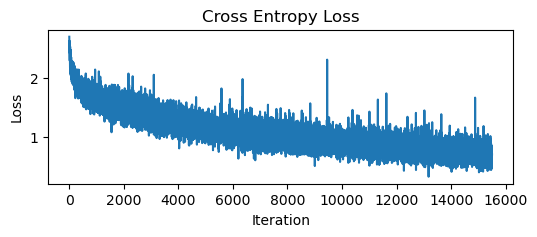

In [24]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            update(loss)
            train_progress.update(1)

        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

In [25]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

model_id = "resnet_with_attention_augmented"
save_path = path.join(".", "models", f"{model_id}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/resnet_with_attention_augmented.pt


# Model Evaluation

In [26]:
# Load Model
model = ResNetImageClassifierWithAttention(num_classes=CLASS_LABELS)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetImageClassifierWithAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [27]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label'] += [train_dataset.classes[i] for i in preds.cpu().detach().numpy().tolist()]

  0%|          | 0/53 [00:00<?, ?it/s]

In [28]:
from datetime import datetime
import pytz

seoul_timezone = pytz.timezone('Asia/Seoul')
seoul_time = datetime.now(seoul_timezone)
curr_time = seoul_time.strftime(r'%m_%d_%H_%M')

In [29]:
# Save Results
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}_{curr_time}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()

File saved to submissions/resnet_with_attention_augmented_08_08_10_20.csv


,id,label
0,TEST_0000,Dessert
1,TEST_0001,Dairy product
2,TEST_0002,Seafood
3,TEST_0003,Meat
4,TEST_0004,Soup
